In [17]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [18]:
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

In [19]:
import numpy as np
train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

for s,l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())

for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [20]:
vocab_size = 1000
embedding_size = 16
max_length = 120
trunc_type = 'post'
oov_token = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded_sequences = pad_sequences(testing_sequences, maxlen=max_length, truncating=trunc_type)

In [21]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
  return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(padded_sequences[3])
print(decode_review(padded_sequences[3]))
print(training_sentences[3])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0  12   7   2 241   5
  20  16   4   1   1   1  52   2 358   5   2 180  68 138   1  17  92 203
 968  15  23   1  81   4 192   1   1   3   1  16   4 376   5 632 387 352
  37   1   3   1   1  15 208   1   1   2 112 365  48  24  55   1   6   1
  55   1   1  41   4   1   3   1   1 141 160 780 111  31  92 116   4 221
  20   9 173 279   3  29  13   1   2   1  10   1]
? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? this is the kind of film for a <OOV> <OOV> <OOV> when the rest of the world can go <OOV> with its own business as you <OOV> into a big <OOV> <OOV> and <OOV> for a couple of hours wonderful performances from <OOV> and <OOV> <OOV> as always <OOV> <OOV> the plot along there are no <OOV> to <OOV> no <OOV> <OOV> just a <OOV> and <OOV> <OOV> through new york life at its best a family film in every sense and one that <OOV> the <OOV> it <OOV>
This is the

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_size, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 11526     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 27,533
Trainable params: 27,533
Non-trainable params: 0
_________________________________________________________________


In [23]:
num_epochs = 10
model.fit(padded_sequences, training_labels, epochs=num_epochs, validation_data=(testing_padded_sequences, testing_labels))

Epoch 1/10
782/782 [==============================] - 3s 3ms/step - loss: 0.5360 - accuracy: 0.7132 - val_loss: 0.4176 - val_accuracy: 0.8080
Epoch 2/10
782/782 [==============================] - 2s 3ms/step - loss: 0.3871 - accuracy: 0.8278 - val_loss: 0.4162 - val_accuracy: 0.8073
Epoch 3/10
782/782 [==============================] - 2s 3ms/step - loss: 0.3319 - accuracy: 0.8581 - val_loss: 0.4404 - val_accuracy: 0.7958
Epoch 4/10
782/782 [==============================] - 2s 3ms/step - loss: 0.2707 - accuracy: 0.8927 - val_loss: 0.4975 - val_accuracy: 0.7834
Epoch 5/10
782/782 [==============================] - 2s 3ms/step - loss: 0.2129 - accuracy: 0.9209 - val_loss: 0.5727 - val_accuracy: 0.7707
Epoch 6/10
782/782 [==============================] - 2s 3ms/step - loss: 0.1622 - accuracy: 0.9443 - val_loss: 0.6715 - val_accuracy: 0.7654
Epoch 7/10
782/782 [==============================] - 2s 3ms/step - loss: 0.1213 - accuracy: 0.9612 - val_loss: 0.7735 - val_accuracy: 0.7588
Epoch 

In [24]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(1000, 16)


In [25]:
import io
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")

out_v.close()
out_m.close()

In [11]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
vocab_size = 1000
embedding_dim = 10
max_len = 50
trunc_type = 'post'
padding_type = 'post'
oov_token = "<OOV>"
training_size = 0.70

In [3]:
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json -O /tmp/sarcasm.json

--2020-07-04 18:05:02--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.146.128, 209.85.200.128, 74.125.124.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.146.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.06s   

2020-07-04 18:05:02 (95.8 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [4]:
with open("/tmp/sarcasm.json", 'r') as f:
  datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
  sentences.append(item['headline'])
  labels.append(item['is_sarcastic'])

In [13]:
l = len(sentences)
size = int(l*training_size)
training_sentences = sentences[:size]
training_labels = labels[:size]
testing_sentences = sentences[size:]
testing_labels = labels[size:]

In [14]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

In [15]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')    
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 10)            10000     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                176       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 10,193
Trainable params: 10,193
Non-trainable params: 0
_________________________________________________________________


In [18]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
585/585 - 1s - loss: 0.6493 - accuracy: 0.6195 - val_loss: 0.5589 - val_accuracy: 0.7710
Epoch 2/30
585/585 - 1s - loss: 0.4606 - accuracy: 0.7974 - val_loss: 0.4198 - val_accuracy: 0.8096
Epoch 3/30
585/585 - 1s - loss: 0.3929 - accuracy: 0.8239 - val_loss: 0.3990 - val_accuracy: 0.8152
Epoch 4/30
585/585 - 1s - loss: 0.3732 - accuracy: 0.8304 - val_loss: 0.3984 - val_accuracy: 0.8098
Epoch 5/30
585/585 - 1s - loss: 0.3627 - accuracy: 0.8372 - val_loss: 0.3935 - val_accuracy: 0.8137
Epoch 6/30
585/585 - 1s - loss: 0.3567 - accuracy: 0.8379 - val_loss: 0.3920 - val_accuracy: 0.8157
Epoch 7/30
585/585 - 1s - loss: 0.3537 - accuracy: 0.8391 - val_loss: 0.3984 - val_accuracy: 0.8183
Epoch 8/30
585/585 - 1s - loss: 0.3507 - accuracy: 0.8428 - val_loss: 0.3941 - val_accuracy: 0.8149
Epoch 9/30
585/585 - 1s - loss: 0.3501 - accuracy: 0.8396 - val_loss: 0.3956 - val_accuracy: 0.8167
Epoch 10/30
585/585 - 1s - loss: 0.3481 - accuracy: 0.8425 - val_loss: 0.3987 - val_accuracy: 0.8111

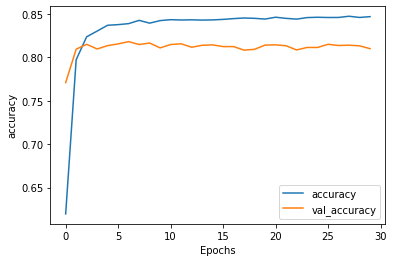

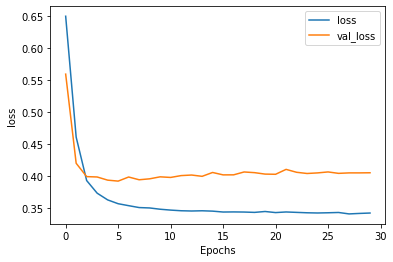

In [19]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [20]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [22]:
def decode_sentence(text):
  return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[2]))
print(training_sentences[2])
print(labels[2])

mom starting to fear <OOV> <OOV> series <OOV> thing she will have to <OOV> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [23]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(1000, 10)


In [25]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embedding = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embedding]) + "\n")

out_v.close()
out_m.close()

In [26]:
from google.colab import files
files.download('vecs.tsv')
files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
import tensorflow_datasets as tfds
import tensorflow as tf
print(tf.__version__)

2.2.0


In [29]:
imdb, info = tfds.load("imdb_reviews/subwords32k", with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords32k/1.0.0.incompleteHVZU2H/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords32k/1.0.0.incompleteHVZU2H/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords32k/1.0.0.incompleteHVZU2H/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords32k/1.0.0. Subsequent calls will reuse this data.


In [31]:
train_data, test_data = imdb['train'], imdb['test']
tokenizer = info.features['text'].encoder

sample_string = "Tensorflow is amazing, not really, sike!"

tokenized_string = tokenizer.encode(sample_string)
print(tokenized_string)

original_string = tokenizer.decode(tokenized_string)
print(original_string)

for ts in tokenized_string:
  print('{} ---> {}'.format(ts, tokenizer.decode([ts])))

[31789, 642, 4477, 8, 1850, 2, 33, 1181, 2, 5390, 3597, 32427]
Tensorflow is amazing, not really, sike!
31789 ---> Tens
642 ---> or
4477 ---> flow 
8 ---> is 
1850 ---> amazing
2 ---> , 
33 ---> not 
1181 ---> really
2 ---> , 
5390 ---> si
3597 ---> ke
32427 ---> !


In [33]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_data.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_data.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_data))

In [34]:
embedding_size = 64
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_size),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(6, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          2089600   
_________________________________________________________________
global_average_pooling1d_2 ( (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 2,089,997
Trainable params: 2,089,997
Non-trainable params: 0
_________________________________________________________________


In [36]:
num_epochs = 10
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 22s 55ms/step - loss: 0.6718 - accuracy: 0.6343 - val_loss: 0.6170 - val_accuracy: 0.7072
Epoch 2/10
391/391 [==============================] - 22s 56ms/step - loss: 0.4969 - accuracy: 0.8144 - val_loss: 0.4255 - val_accuracy: 0.8436
Epoch 3/10
391/391 [==============================] - 22s 57ms/step - loss: 0.3359 - accuracy: 0.8838 - val_loss: 0.3576 - val_accuracy: 0.8581
Epoch 4/10
391/391 [==============================] - 22s 57ms/step - loss: 0.2560 - accuracy: 0.9156 - val_loss: 0.3186 - val_accuracy: 0.8733
Epoch 5/10
391/391 [==============================] - 21s 55ms/step - loss: 0.2064 - accuracy: 0.9315 - val_loss: 0.3026 - val_accuracy: 0.8813
Epoch 6/10
391/391 [==============================] - 22s 55ms/step - loss: 0.1725 - accuracy: 0.9446 - val_loss: 0.2953 - val_accuracy: 0.8850
Epoch 7/10
391/391 [==============================] - 21s 54ms/step - loss: 0.1439 - accuracy: 0.9556 - val_loss: 0.3024 - val_accuracy:

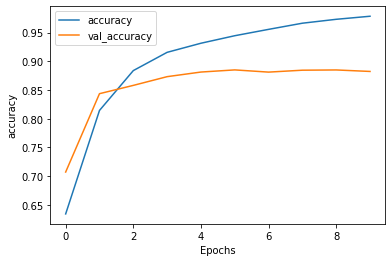

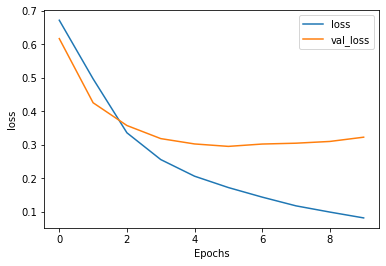

In [37]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")